This is my first ever submitred file to a kaggle competition.
I picked the Iowa Home Prices predicted competition because i wanted a basic well defined problem which i can practice basic steps of data science skills:

workflow:
1.	Data Cleaning and Pre-processing(Explained variable)‎
•	Outliers
•	Statistical transformations

2.	Feature Engineering
•	Concatenation
•	NA's
•	Factorization
•	Further Statistical transformation
•	Column removal
•	Dummies
•	Baseline model

3.	Feature Selection
•	Filter methods
	L1: Ridge Regression
	L2: Lasso regression
	Elasticnet

4.	Prediction

5. improving the model:
	Ensemble methods
•	Stacked generalizations
•	Averaging
	standard
	weighted



In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


In [3]:
#define helper functions

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

def plot_ecdf(x,y,xname):
    #plot the culminative probability of every value in a series
    plt.plot(x,y,marker='.',linestyle='none')
    plt.xlabel(xname)
    plt.ylabel('Culmanative Probability')
    plt.show()
    
def compare_normality(var):
    #plot the ecdf  of  a series against a normal distribution with the same expectancy and standart deveation

    np.random.seed(seed=42)
    x_norm,y_norm=ecdf(np.random.normal(loc=np.mean(var),scale=np.std(var),size=len(var)))
    x_var,y_var=ecdf(var)
    plt.plot(x_norm,y_norm,marker='.',linestyle='none',color='black')
    plt.plot(x_var,y_var,marker='.',linestyle='none',color='red')
    plt.xlabel('random distribution vs.'+ str(var.name) )
    plt.ylabel('Culmanative Probability')
    plt.legend({'norm':x_norm, 'price':str(var.name) })
    plt.show()
    
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

#A function to calculate Root Mean Squared Error (RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmsle(model):
#A function to calculate Root Mean Squared Error per validation segment
    rmsle = np.sqrt(np.log(-cross_val_score(model, X, y,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)

In [4]:
#Data loading
test=pd.read_csv('D:\\Python\\python projects\\home prices\\test.csv',index_col='Id')
train=pd.read_csv('D:\\Python\\python projects\\home prices\\train.csv',index_col='Id')
target=train.SalePrice

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

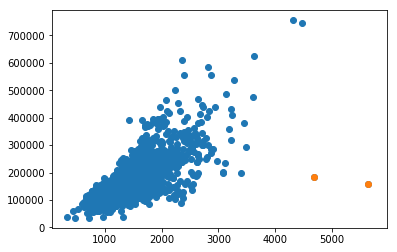

In [6]:
#Understanding the explained variable
plt.figure()
plt.scatter(train.GrLivArea,train.SalePrice)
plt.scatter(train['GrLivArea'][train['GrLivArea']>4500],train.SalePrice[train['GrLivArea']>4500])

 we can see that there are two obvious outliers regarding the relation between proparty size and price, we will solve this by getting rid of observation where the size is ridiculesly large

In [7]:
train=train[train['GrLivArea']<4500]

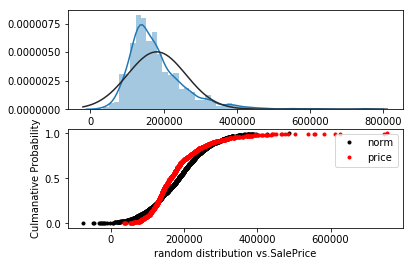

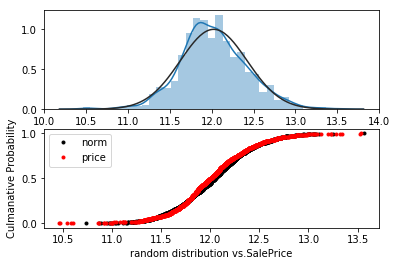

In [8]:
#Understanding the explained variable
plt.scatter(train.GrLivArea,train.SalePrice)
train=train[train['GrLivArea']<4500]
plt.scatter(train.GrLivArea,train.SalePrice)

plt.subplot(2,1,1)
sns.distplot(target,fit=stats.norm)
plt.subplot(2,1,2)
compare_normality(target)

plt.figure()
plt.subplot(2,1,1)
sns.distplot(np.log1p(target),fit=stats.norm)
plt.subplot(2,1,2)
compare_normality(np.log1p(target))
plt.show()

target=np.log1p(target)

the explained variable(SalePrice) is somewhat skewed, log1p seems to solve the problam

In [9]:
# =============================================================================
# Feature Engeneering
# =============================================================================
#concatanating test and train: df
df=pd.concat([train,test], sort=False)

#Imputing NA
null_sum=df.isna().sum().sort_values(ascending=False)
null_sum=null_sum[null_sum!=0]
print(null_sum)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageCars         1
BsmtFinSF2         1
Exterior2nd        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
Exterior1st        1
KitchenQual        1
SaleType           1
Electrical         1
dtype: int64


In [10]:
#handeling garage variables: 
#first, imputing variables to the 2 variables where there is a garage but rest of the variabls are NA
#second, replacing NA with 0
print(df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']][df['GarageType'].notna( ) & df['GarageQual'].isna() ])
df[['GarageQual','GarageFinish','GarageCond']].groupby(df['GarageType']).agg(pd.Series.mode)


     GarageType  GarageYrBlt GarageFinish GarageCond GarageQual
Id                                                             
2127     Detchd          NaN          NaN        NaN        NaN
2577     Detchd          NaN          NaN        NaN        NaN


,GarageQual,GarageFinish,GarageCond
GarageType,,,
2Types,TA,Unf,TA
Attchd,TA,RFn,TA
Basment,TA,Unf,TA
BuiltIn,TA,Fin,TA
CarPort,TA,Unf,TA
Detchd,TA,Unf,TA


In [11]:
df['GarageFinish'][df['GarageFinish'].isna() & df['GarageType'].notna()]='Unf'
df['GarageCond'][df['GarageCond'].isna() & df['GarageType'].notna()]='TA' 
df['GarageQual'][df['GarageQual'].isna() & df['GarageType'].notna()]='TA' 
df['GarageYrBlt'][df['GarageYrBlt'].isna() & df['GarageType'].notna()]=df['YearRemodAdd']
df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']]=df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']].fillna(0)


In [12]:
print(df[['GarageCond','GarageQual','GarageArea','GarageCars']][df['GarageCars'].isna()])
print(df[['GarageCond','GarageQual','GarageArea','GarageCars']].groupby(['GarageCond','GarageQual']).mean())
df['GarageCars']=df['GarageCars'].fillna(2)
df['GarageArea']=df['GarageArea'].fillna(508)

     GarageCond GarageQual  GarageArea  GarageCars
Id                                                
2577         TA         TA         NaN         NaN
                       GarageArea  GarageCars
GarageCond GarageQual                        
0          0             0.000000    0.000000
Ex         Ex          612.000000    1.000000
           Gd          576.000000    2.000000
Fa         Fa          316.743590    1.384615
           Po          195.000000    1.000000
           TA          356.470588    1.411765
Gd         Gd          562.500000    2.000000
           TA          604.666667    2.000000
Po         Fa          331.625000    1.500000
           Po          301.000000    1.000000
           TA          240.500000    1.000000
TA         Ex          840.000000    3.000000
           Fa          342.584416    1.324675
           Gd          666.647059    1.941176
           TA          507.963643    1.898749


In [13]:
df['HasGarage']=df['GarageArea'].apply(lambda x: 0 if x==0 else 1)

In [14]:
#handeling BSMT variables
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()])
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby('BsmtFinType1').agg(pd.Series.mode))

    BsmtExposure BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                          
333           No       TA       Gd          NaN          GLQ
             BsmtExposure BsmtCond BsmtQual BsmtFinType2
BsmtFinType1                                            
ALQ                    No       TA       TA          Unf
BLQ                    No       TA       TA          Unf
GLQ                    No       TA       Gd          Unf
LwQ                    No       TA       TA          Unf
Rec                    No       TA       TA          Unf
Unf                    No       TA       TA          Unf


In [15]:
df['BsmtExposure'][df['BsmtFinType2'].isna() & df['BsmtFinType1'].notna()]=df['BsmtExposure'].fillna('No')
df['BsmtQual'][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]=df['BsmtQual'].fillna('Gd')
df['BsmtFinType2'][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]=df['BsmtFinType2'].fillna('Unf')


In [16]:
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtQual'].isna() &df['BsmtFinType1'].notna()])
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby(['BsmtFinType1','BsmtFinType2']).agg(pd.Series.mode))
df['BsmtQual'][df['BsmtQual'].isna() &df['BsmtFinType1'].notna()]=df['BsmtQual'].fillna('TA')


     BsmtExposure BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
2218           No       Fa      NaN          Unf          Unf
2219           No       TA      NaN          Unf          Unf
                          BsmtExposure BsmtCond  BsmtQual
BsmtFinType1 BsmtFinType2                                
ALQ          BLQ                    No       TA        TA
             GLQ                    No       TA        TA
             LwQ                    No       TA        Gd
             Rec                    No       TA        TA
             Unf                    No       TA        TA
BLQ          ALQ                    No       TA  [Gd, TA]
             BLQ                    No       TA        Gd
             GLQ                    Av       TA        Gd
             LwQ                    No       TA        TA
             Rec                    No       TA        TA
             Unf                    No       TA        T

In [17]:
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtCond'].isna() &df['BsmtFinType1'].notna()])
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby(['BsmtQual','BsmtFinType1']).agg(pd.Series.mode))
df['BsmtCond']=df['BsmtCond'].fillna('TA')

     BsmtExposure BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
2041           Mn      NaN       Gd          Rec          GLQ
2186           No      NaN       TA          Unf          BLQ
2525           Av      NaN       TA          Unf          ALQ
                      BsmtExposure  BsmtCond BsmtFinType2
BsmtQual BsmtFinType1                                    
Ex       ALQ                    No        TA          Unf
         BLQ                    Mn        TA          GLQ
         GLQ                    Gd        TA          Unf
         LwQ              [Mn, No]  [Gd, TA]   [ALQ, GLQ]
         Rec              [Av, Gd]        TA          GLQ
         Unf                    No        TA          Unf
Fa       ALQ                    No        TA          Unf
         BLQ                    Mn        TA          Unf
         LwQ                    No        TA          Unf
         Rec                    No        TA        

In [18]:
print(df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtExposure'].isna() &df['BsmtFinType1'].notna()])
print(df[['BsmtExposure','BsmtQual','BsmtFinType1']].groupby(['BsmtQual','BsmtFinType1']).agg(pd.Series.mode))
df['BsmtExposure'][df['BsmtExposure'].isna() &df['BsmtFinType1'].notna()]=df['BsmtExposure'].fillna('No')

     BsmtExposure BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
949           NaN       TA       Gd          Unf          Unf
1488          NaN       TA       Gd          Unf          Unf
2349          NaN       TA       Gd          Unf          Unf
                      BsmtExposure
BsmtQual BsmtFinType1             
Ex       ALQ                    No
         BLQ                    Mn
         GLQ                    Gd
         LwQ              [Mn, No]
         Rec              [Av, Gd]
         Unf                    No
Fa       ALQ                    No
         BLQ                    Mn
         LwQ                    No
         Rec                    No
         Unf                    No
Gd       ALQ                    No
         BLQ                    No
         GLQ                    No
         LwQ                    No
         Rec                    No
         Unf                    No
TA       ALQ             

In [19]:
print(df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtUnfSF'].isna()])
print(df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtFullBath'].isna()])
print(df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtHalfBath'].isna()])

#we'll fill in the rest with zero's and create a classifing dummy variable


      TotalBsmtSF BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
2121          NaN       TA      NaN          NaN          NaN
      TotalBsmtSF BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
2121          NaN       TA      NaN          NaN          NaN
2189          0.0       TA      NaN          NaN          NaN
      TotalBsmtSF BsmtCond BsmtQual BsmtFinType2 BsmtFinType1
Id                                                           
2121          NaN       TA      NaN          NaN          NaN
2189          0.0       TA      NaN          NaN          NaN


In [20]:
bsmt_var=['BsmtHalfBath','TotalBsmtSF','BsmtFullBath','BsmtExposure','BsmtUnfSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFinSF1','BsmtFinSF2']
for var in bsmt_var:
    df[var]=df[var].fillna(0)

df['HasBsmt']=df['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)

In [21]:
#other vars:
print(df['KitchenQual'].groupby(df['OverallQual']).agg(pd.Series.mode))
print(df['OverallQual'][df['KitchenQual'].isna()])
df['KitchenQual']=df['KitchenQual'].fillna('TA')

OverallQual
1     Fa
2     TA
3     TA
4     TA
5     TA
6     TA
7     Gd
8     Gd
9     Ex
10    Ex
Name: KitchenQual, dtype: object
Id
1556    5
Name: OverallQual, dtype: int64


In [22]:
df.Electrical=df.Electrical.fillna(df.Electrical.value_counts()[0])
df.Exterior1st=df.Exterior1st.fillna(df.Exterior1st.value_counts()[0])
df.Exterior2nd=df.Exterior2nd.fillna(df.Exterior2nd.value_counts()[0])
df.SaleType=df.SaleType.fillna(df.SaleType.value_counts()[0])
df.Utilities=df.Utilities.fillna(df.Utilities.value_counts()[0])
df.Functional=df.Functional.fillna(df.Functional.value_counts()[0])

print(df[['MSZoning','Neighborhood']][df['MSZoning'].isna()])
print(df[['Neighborhood','MSZoning']].groupby('Neighborhood').agg(pd.Series.mode))
df.loc[2905,'MSZoning']='RL'
df.MSZoning=df.MSZoning.fillna('RM')

     MSZoning Neighborhood
Id                        
1916      NaN       IDOTRR
2217      NaN       IDOTRR
2251      NaN       IDOTRR
2905      NaN      Mitchel
             MSZoning
Neighborhood         
Blmngtn            RL
Blueste            RM
BrDale             RM
BrkSide            RM
ClearCr            RL
CollgCr            RL
Crawfor            RL
Edwards            RL
Gilbert            RL
IDOTRR             RM
MeadowV            RM
Mitchel            RL
NAmes              RL
NPkVill            RL
NWAmes             RL
NoRidge            RL
NridgHt            RL
OldTown            RM
SWISU              RL
Sawyer             RL
SawyerW            RL
Somerst            FV
StoneBr            RL
Timber             RL
Veenker            RL


In [23]:
print(df['Fireplaces'][df['FireplaceQu'].isna() & df['Fireplaces']!=0])
df['Fireplaces']=df['Fireplaces'].fillna(0)
df['FireplaceQu']=df['FireplaceQu'].fillna(0)
df['HasFireplaces']=df['Fireplaces'].apply(lambda x: 0 if x==0 else 1)

print(df['PoolQC'][df['PoolQC'].isna() & df['PoolArea']!=0])
df['PoolQC']=df['PoolQC'].fillna(0)

df['HasPool']=df['PoolArea'].apply(lambda x: 0 if x==0 else 1)
        
df['Fence']=df['Fence'].fillna(0)
df['HasFence']=df['Fence'].apply(lambda x: 0 if x==0 else 1)

df['Alley']=df['Alley'].fillna(0)
df['HasAlleyAccsess']=df['Alley'].apply(lambda x: 0 if x==0 else 1)
        
df['MiscFeature']=df['MiscFeature'].fillna(0) 
df=df.rename(columns = {'MiscFeature':'HasMiscFeature'})
df['HasMiscFeature']=df['HasMiscFeature'].apply(lambda x: 0 if x==0 else 1)

df[['LotFrontage','Neighborhood']][df.LotFrontage.isna()]
lotneigh=df.LotFrontage.groupby(df.Neighborhood).mean()
for id in df[['LotFrontage','Neighborhood']][df.LotFrontage.isna()].index:
    neigh=df.loc[id,'Neighborhood']
    df.loc[id,'LotFrontage']=lotneigh[neigh]


Series([], Name: Fireplaces, dtype: int64)
Id
2600    NaN
Name: PoolQC, dtype: object


we'll create some new binary features that help indicate on the existance of any special feuature

In [24]:
df['HasPool']=df['PoolArea'].apply(lambda x: 0 if x==0 else 1)
        
df['Fence']=df['Fence'].fillna(0)
df['HasFence']=df['Fence'].apply(lambda x: 0 if x==0 else 1)

df['Alley']=df['Alley'].fillna(0)
df['HasAlleyAccsess']=df['Alley'].apply(lambda x: 0 if x==0 else 1)
        
df['MiscFeature']=df['MiscFeature'].fillna(0) 
df=df.rename(columns = {'MiscFeature':'HasMiscFeature'})
df['HasMiscFeature']=df['HasMiscFeature'].apply(lambda x: 0 if x==0 else 1)

KeyError: 'MiscFeature'

In [25]:
print(df.MasVnrArea.value_counts().sort_values(ascending=False))
df[['MasVnrType','MasVnrArea']][df.MasVnrType.isna() & df.MasVnrArea.notna()]='BrkFace'
df.MasVnrType=df.MasVnrType.fillna('None')
df.MasVnrArea=df.MasVnrArea.fillna(0)


0.0       1738
120.0       15
200.0       13
176.0       13
216.0       12
180.0       12
144.0       11
72.0        11
108.0       11
16.0        11
340.0       10
210.0        9
128.0        9
196.0        9
80.0         9
256.0        8
40.0         8
302.0        8
178.0        8
132.0        8
170.0        8
300.0        7
140.0        7
60.0         7
44.0         7
174.0        7
76.0         7
320.0        7
270.0        7
240.0        7
          ... 
481.0        1
235.0        1
860.0        1
355.0        1
734.0        1
109.0        1
426.0        1
692.0        1
406.0        1
418.0        1
400.0        1
64.0         1
207.0        1
397.0        1
1095.0       1
299.0        1
223.0        1
562.0        1
412.0        1
225.0        1
175.0        1
495.0        1
127.0        1
388.0        1
518.0        1
348.0        1
470.0        1
229.0        1
760.0        1
217.0        1
Name: MasVnrArea, Length: 442, dtype: int64


In [26]:
null_sum=df.isna().sum().sort_values(ascending=False)
null_sum=null_sum[null_sum!=0]
print(null_sum)

SalePrice    1459
dtype: int64


Feature type seperation and Factorization

In [27]:
#seperatin Categorical features and nums
nums=df.select_dtypes(np.number)
categories=df.select_dtypes(exclude=np.number)
print(nums.shape)
print(nums.describe())
print(categories.shape)
print(categories.info)


#Factorization
nums.columns
fake_nums=['HasFireplaces','GarageYrBlt','MSSubClass','HasMiscFeature','MoSold','YrSold', 'HasGarage', 'HasBsmt', 'HasPool', 'HasFence', 'HasAlleyAccsess']
fakes=nums[fake_nums]
fakes=fakes.astype('object',copy=False)
nums=nums.drop(fake_nums,axis=1)
categories=pd.concat([categories,fakes],axis=1)
categories=categories.astype('category',copy=False)
categories.info()

(2917, 44)
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2917.000000  2917.000000    2917.000000  2917.000000  2917.000000   
mean     57.135756    69.848739   10139.439150     6.086390     5.564964   
std      42.532140    21.227945    7807.036512     1.406704     1.113414   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7476.000000     5.000000     5.000000   
50%      50.000000    70.000000    9452.000000     6.000000     5.000000   
75%      70.000000    80.000000   11556.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  2917.000000   2917.000000  2917.000000  2917.000000  2917.000000   
mean   1971.287967   1984.248200   100.931436   438.864930    49.599246   
std      30.286991     20.892257   178.032499   444.180542   169.232130   
min 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 53 columns):
MSZoning           2917 non-null category
Street             2917 non-null category
Alley              2917 non-null category
LotShape           2917 non-null category
LandContour        2917 non-null category
Utilities          2917 non-null category
LotConfig          2917 non-null category
LandSlope          2917 non-null category
Neighborhood       2917 non-null category
Condition1         2917 non-null category
Condition2         2917 non-null category
BldgType           2917 non-null category
HouseStyle         2917 non-null category
RoofStyle          2917 non-null category
RoofMatl           2917 non-null category
Exterior1st        2917 non-null category
Exterior2nd        2917 non-null category
MasVnrType         2917 non-null category
ExterQual          2917 non-null category
ExterCond          2917 non-null category
Foundation         2917 non-null category
BsmtQual   

In [28]:
mode_freq={}
for var in df.columns:
    freq=df[var].value_counts()[df[var].mode()[0]]/len(df[var])
    mode_freq[var]=freq
freq=pd.Series(mode_freq,index=mode_freq.keys())
unvaried=freq[freq>=0.95]
print(unvaried)
df=df.drop(unvaried.index,axis=1)#unifing repetative fetures


Street            0.995886
Utilities         0.998972
LandSlope         0.951663
Condition2        0.990058
RoofMatl          0.985602
Heating           0.984573
LowQualFinSF      0.986287
KitchenAbvGr      0.954062
3SsnPorch         0.987316
PoolArea          0.995886
PoolQC            0.996915
HasMiscFeature    0.964004
MiscVal           0.964690
HasBsmt           0.972917
HasPool           0.995886
dtype: float64


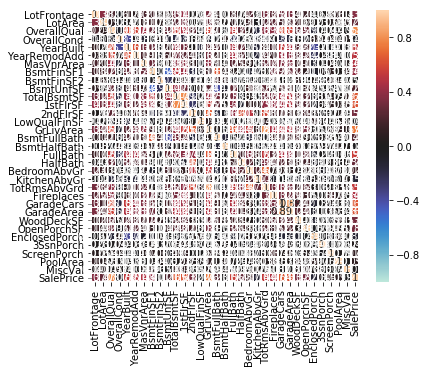

In [29]:
inner=nums.corr()
high_colinear=inner[inner>.75]
high_colinear.replace(to_replace=1,value=np.nan,inplace=True)
high_colinear=high_colinear.dropna(how='all',axis=1).dropna(how='all',axis=0)
colin_pairs=[]
for column in high_colinear.columns:
    row=high_colinear[column].idxmax()
    colin_pairs.append([row,column])

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(inner, annot=True, xticklabels=inner.columns, 
            yticklabels=inner.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)


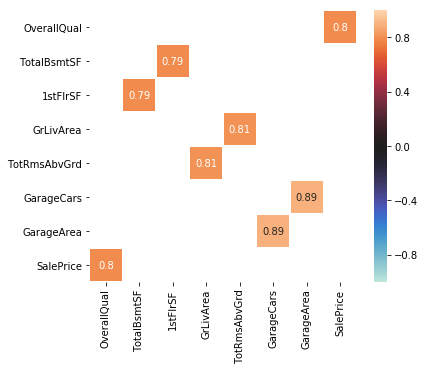

In [30]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(high_colinear, annot=True, xticklabels=high_colinear.columns, 
            yticklabels=high_colinear.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)


In [31]:
#we will create some new features and then get rid of the colineared ones

vars=sorted(list(df.columns))
df['TotalSF']=df['1stFlrSF']+df['2ndFlrSF']+df['GrLivArea']+df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalPorchSF']=df['OpenPorchSF']+df['EnclosedPorch']+df['ScreenPorch']
df['TotalBath']=df['BsmtFullBath']+(df['BsmtHalfBath']*.5)+df['FullBath']+(df['HalfBath']*.5)
df=df.drop(['EnclosedPorch','ScreenPorch','OpenPorchSF'],axis=1)
df=df.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1)
df=df.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'],axis=1)

In [32]:
#numeric values Skew exploration

skewness=nums.skew(axis=0).sort_values(ascending=False)
skewd_list=skewness[abs(skewness)>(0.5)].index
print(skewd_list)
skewd=nums[skewd_list]
skewd.info()

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'SalePrice', 'WoodDeckSF',
       '1stFlrSF', 'GrLivArea', 'LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF',
       '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'TotalBsmtSF',
       'BsmtFullBath', 'OverallCond', 'YearBuilt'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 27 columns):
MiscVal          2917 non-null int64
PoolArea         2917 non-null int64
LotArea          2917 non-null int64
LowQualFinSF     2917 non-null int64
3SsnPorch        2917 non-null int64
KitchenAbvGr     2917 non-null int64
BsmtFinSF2       2917 non-null float64
EnclosedPorch    2917 non-null int64
ScreenPorch      2917 non-null int64
BsmtHalfBath     2917 non-null float64
MasVnrArea       2917 non-null float64
OpenPorchSF      2917 non-null int64
S

In [33]:
for var in skewd.columns:
    skewd[var]=np.log1p(skewd[var])
    df[var]=skewd[var]
    print(var+' transformed')        
log_skewness=skewd.skew(axis=0).sort_values(ascending=False)

MiscVal transformed
PoolArea transformed
LotArea transformed
LowQualFinSF transformed
3SsnPorch transformed
KitchenAbvGr transformed
BsmtFinSF2 transformed
EnclosedPorch transformed
ScreenPorch transformed
BsmtHalfBath transformed
MasVnrArea transformed
OpenPorchSF transformed
SalePrice transformed
WoodDeckSF transformed
1stFlrSF transformed
GrLivArea transformed
LotFrontage transformed
BsmtFinSF1 transformed
BsmtUnfSF transformed
2ndFlrSF transformed
TotRmsAbvGrd transformed
Fireplaces transformed
HalfBath transformed
TotalBsmtSF transformed
BsmtFullBath transformed
OverallCond transformed
YearBuilt transformed


In [34]:
#creating dummies
categories1=df.select_dtypes(exclude=np.number)
nums1=df.select_dtypes(np.number)
for var in list(categories1.columns):
    df[var]=df[var].astype('category',copy=False)
df[categories1.columns].dtypes
df1=pd.get_dummies(df)

train=df1.loc[:len(target),:]
test=df1.loc[len(target)+1:,:]

In [35]:
# =============================================================================
# #create regression models
# =============================================================================
X=train.drop('SalePrice',axis=1)
y=train.SalePrice

X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)


kfolds = KFold(n_splits=10, shuffle=True, random_state=23)
lm=linear_model.LinearRegression()
scaler=preprocessing.RobustScaler()
ridge=linear_model.Ridge(alpha=6.099999999999998)
lasso=linear_model.Lasso(alpha=0.00032, max_iter=10e5)
net=linear_model.ElasticNetCV()


In [36]:
r_alphas ={'alpha': [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 6, 10, 15, 20, 30, 50, 60, 70, 80]}
ridge_CV=GridSearchCV(ridge,r_alphas ,cv=10)
ridge_CV.fit(X_train,y_train)
ridge_pred=ridge_CV.predict(X_test)

print('best params: '+str(ridge_CV.best_params_))
print('Ridge Regression score: '+str(ridge_CV.score(X_test,y_test)))
print('RIdge Regression root mean square error: '+str(rmsle(y_test,ridge_pred)))

best params: {'alpha': 15}
Ridge Regression score: 0.9134725749163451
RIdge Regression root mean square error: 0.11658929087112559


In [37]:
r_alphas2={'alpha': np.arange(10, 20, 0.5)}
ridge_CV=GridSearchCV(ridge,r_alphas2 ,cv=10)
ridge_CV.fit(X_train,y_train)
print('best params: '+str(ridge_CV.best_params_))
print('Ridge Regression score: '+str(ridge_CV.score(X_test,y_test)))
print('RIgge Regression root mean square error: '+str(rmsle(y_test,ridge_pred)))

best params: {'alpha': 13.0}
Ridge Regression score: 0.9140908336538651
RIgge Regression root mean square error: 0.11658929087112559


In [39]:
r_alphas3={'alpha': np.arange(12.5, 13.5, 0.1)}
ridge_CV=GridSearchCV(ridge,r_alphas3 ,cv=10)
ridge_CV=ridge_CV.fit(X_train,y_train)
ridge_pred=ridge_CV.predict(X_test)
print('best params: '+str(ridge_CV.best_params_))
print('Ridge Regression score: '+str(ridge_CV.score(X_test,y_test)))
print('RIdge Regression root mean square error: '+str(rmsle(y_test,ridge_pred)))

best params: {'alpha': 12.799999999999999}
Ridge Regression score: 0.9141552994076468
RIdge Regression root mean square error: 0.11612841965127131


In [40]:
l_alphas={'alpha':[0.000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]}
l_alphas1={'alpha':np.arange(0.0003,0.0004,0.00001)}
lasso_CV=GridSearchCV(lasso,l_alphas1 ,cv=10)
lasso_CV=lasso_CV.fit(X_train,y_train)
lasso_pred=lasso_CV.predict(X_test)
print('best params: '+str(lasso_CV.best_params_))
print('Lasso Regression score: '+str(lasso_CV.score(X_test,y_test)))
print('Lasso Regression root mean square error: '+str(rmsle(y_test,lasso_pred)))

best params: {'alpha': 0.00040000000000000024}
Lasso Regression score: 0.9223176786285383
Lasso Regression root mean square error: 0.1104696220953752


In [45]:
net_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1]
net_alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
net=linear_model.ElasticNetCV(l1_ratio=net_ratio,alphas=net_alphas ,cv=10)
net=net.fit(X_train,y_train)
net_pred=net.predict(X_test)
print('Elastic net score: '+str(net.score(X_test,y_test)))
print('Elastic net root mean square error: '+str(rmsle(y_test,net_pred)))

Elastic net score: 0.9208864015076729
Elastic net root mean square error: 0.11148266455198344


In [41]:

test=test.drop('SalePrice',axis=1)
SalePrice=ridge_CV.predict(test)
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
ID
# =============================================================================
# 
# sumitting File to competition
# selected model - Ridge regressor alpha=6.1
# =============================================================================
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission.csv',index=False)


In [42]:
# =============================================================================
# 10.04 - best score so far (for submission file) - .11896 (846/4461)
# Outliers detection
# =============================================================================
import statsmodels.api as sm

#OLS stands for ordinary least squares. it analyzez the array and returns an outliers detection
ols = sm.OLS(endog = y, exog = X)
fit=ols.fit()

#There are several outlier test that are part o statmodels.OLS.outlier_test(), bonf(p) is the default.
#it anyalizes the probability of each indice in the array to not be an outlier, and returns the p-values
#we gonna stamp out each data point that it's probability of NOT being an outlier is smaller than alpha (0.01)
OE= fit.outlier_test()['bonf(p)']
liers_alpha=0.001
liers=OE[OE<liers_alpha]
drop_them=list(liers.index)
print(drop_them)
train=train.drop(drop_them,axis=0)
y=y.drop(drop_them,axis=0)

[89, 463, 589, 633, 969, 1325]


In [46]:
ridge_CV=ridge_CV.fit(X_train,y_train)
ridge_pred=ridge_CV.predict(X_test)
print('Ridge Regression score: '+str(ridge_CV.score(X_test,y_test)))
print('RIdge Regression root mean square error: '+str(rmsle(y_test,ridge_pred)))
lasso_CV=lasso_CV.fit(X_train,y_train)
lasso_pred=lasso_CV.predict(X_test)
print('Lasso Regression score: '+str(lasso_CV.score(X_test,y_test)))
print('Lasso Regression root mean square error: '+str(rmsle(y_test,lasso_pred)))
net=net.fit(X_train,y_train)
net_pred=net.predict(X_test)
print('Elastic net score: '+str(net.score(X_test,y_test)))
print('Elastic net root mean square error: '+str(rmsle(y_test,net_pred)))


Ridge Regression score: 0.9141552994076468
RIdge Regression root mean square error: 0.11612841965127131
Lasso Regression score: 0.9223176786285383
Lasso Regression root mean square error: 0.1104696220953752
Elastic net score: 0.9208864015076729
Elastic net root mean square error: 0.11148266455198344


expirementing in enssamble methods

In [48]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


KRR.fit(X_train,y_train)
krr_pred=KRR.predict(X_test)
print('KRR score: '+str(KRR.score(X_test,y_test)))
print('KRR root mean square error: '+str(rmsle(y_test,krr_pred)))

GBoost.fit(X_train,y_train)
gboost_pred=GBoost.predict(X_test)
print('GBoost score: '+str(GBoost.score(X_test,y_test)))
print('GBoost root mean square error: '+str(rmsle(y_test,gboost_pred)))
      



KRR score: 0.6130921176528155
KRR root mean square error: 0.24653895997640407
GBoost score: 0.9092120154439955
GBoost root mean square error: 0.11942519480071602


i borrowed this class code from a kernel where i saw it was used for avereging different models together. at the end t's not nessecery sience a simple mean function does the same thing.

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin,clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [57]:
averaged_models = AveragingModels(models = (net, ridge_CV, lasso_CV,GBoost))
averaged_models.fit(X_train,y_train)
ave_pred=averaged_models.predict(X_test)
print('Model averages score: '+str(averaged_models.score(X_test,y_test)))
print('Model averages error: '+str(rmsle(y_test,ave_pred)))
average_pred=ridge_pred*0.25+lasso_pred*.25+net_pred*.25+gboost_pred*.25
print('Model averages error: '+str(rmsle(y_test,average_pred)))


Model averages score: 0.921778292493561
Model averages error: 0.11085248080583165
Model averages error: 0.1108524808058317


In [58]:
average_pred=ridge_pred*0.25+lasso_pred*.25+net_pred*.25+gboost_pred*.25
print('Model averages error: '+str(rmsle(y_test,average_pred)))

Model averages error: 0.1108524808058317


In [59]:
#Submission 2 - score - 0.11577 (571/4461)

SalePrice=ridge_CV.predict(test)*.25+lasso_CV.predict(test)*.25+net.predict(test)*.25+GBoost.predict(test)*.25
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
ID
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_no_outliers.csv',index=False)

11.04 - today i expiramented with XGBoost.
i did the mistake of running a SearchGrird with 8 variables!!!! Never do it! it took more than 6 hours to compile!
at the end i found a set of hyper parameters that i put into the code

i put the code here so ill never accidentelyrun it again:

xgbreg=xgb.XGBRegressor(objective= 'reg:linear',seed=42)
grid_params={
        'learning_rate':[0.01,0.05,0.1,0.3],
        'n_estimators':np.arange(1000,6000,1000),
        'max_depth':[2,3,4,5,6],
        'colsample_bytree':np.arange(0.5,1,0.1),
        'min_child_weight':[0,0.1,0.2,0.6],
        'gamma':[0,0.000001,0.00001,0.0001,.001,.01],
        'subsample':np.arange(0.5,1,.1),
        'reg_alpha':[0,0.000001,0.00001,0.0001,.001,.01]}
grid_search=GridSearchCV(cv=4,estimator=xgbreg,param_grid=grid_params,scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

In [62]:
import xgboost as xgb
xgbreg=xgb.XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',seed=42, reg_alpha=0.00006)
xgbreg=xgbreg.fit(X_train,y_train)
xgbreg_pred=xgbreg.predict(X_test)
print('xgbreg score: '+str(xgbreg.score(X_test,y_test)))
print('xbgreg root mean square error ' +str(rmsle(y_test,xgbreg_pred)))

xgbreg score: 0.9157134250923353
xbgreg root mean square error 0.1150696981474898


In [69]:
methods={'Ridge Regression':ridge_CV, 'Lasso Regression':lasso_CV,
         'Elastic net':net,'Gradient boosting':GBoost, 'Extreme gradient boosting':xgbreg,
         'All models average':averaged_models}
scoring={}
for name,model in methods.items():
        scoring[name]={'Score':model.score(X_test,y_test),
                       'Root mean square error':rmsle(y_test,model.predict(X_test))}

print (scoring)

{'Ridge Regression': {'Score': 0.9141552994076468, 'Root mean square error': 0.11612841965127131}, 'Lasso Regression': {'Score': 0.9223176786285383, 'Root mean square error': 0.1104696220953752}, 'Elastic net': {'Score': 0.9208864015076729, 'Root mean square error': 0.11148266455198344}, 'Gradient boosting': {'Score': 0.9092120154439955, 'Root mean square error': 0.11942519480071602}, 'Extreme gradient boosting': {'Score': 0.9157134250923353, 'Root mean square error': 0.1150696981474898}, 'All models average': {'Score': 0.921778292493561, 'Root mean square error': 0.11085248080583165}}


In [70]:
rmsle(ridge_CV.predict(X_test)*.2+lasso_CV.predict(X_test)*.2+net.predict(X_test)*.2+GBoost.predict(X_test)*.2+xgbreg.predict(X_test)*.2,y_test)

0.11027315735897908

In [71]:
SalePrice=ridge_CV.predict(test)*.2+lasso_CV.predict(test)*.2+net.predict(test)*.2+GBoost.predict(test)*.2+xgbreg.predict(test)*.2
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
ID
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_no_outliers.csv',index=False)

14.04
so far i got best score at 0.11577 (581/4461)
next up i'm going to try stacking models with stack regression and averaging all together with a simple mean and with a siple weighted mean(where the best method get's about double the weight)  

In [73]:
from mlxtend.regressor import StackingCVRegressor

stack = StackingCVRegressor(regressors=(ridge_CV,lasso_CV,net,GBoost,averaged_models,xgbreg),meta_regressor=xgbreg,
                               use_features_in_secondary=True)
stackX = np.array(X_train)
stacky = np.array(y_train)
stack = stack.fit(stackX, stacky)
stack_pred=stack.predict(np.array(X_test))
print('Stacked Model averages score: '+str(stack.score(np.array(X_test),np.array(y_test))))
print('Stacked Model averages error: '+str(rmsle(y_test,stack_pred)))

Stacked Model averages score: 0.9181671643163147
Stacked Model averages error: 0.113382380561928


In [74]:
scoring[name]={'Stacked Regressor':model.score(np.array(X_test),np.array(y_test)),
                       'Root mean square error':rmsle(y_test,model.predict(np.array(X_test)))}
scoring

{'Ridge Regression': {'Score': 0.9141552994076468,
  'Root mean square error': 0.11612841965127131},
 'Lasso Regression': {'Score': 0.9223176786285383,
  'Root mean square error': 0.1104696220953752},
 'Elastic net': {'Score': 0.9208864015076729,
  'Root mean square error': 0.11148266455198344},
 'Gradient boosting': {'Score': 0.9092120154439955,
  'Root mean square error': 0.11942519480071602},
 'Extreme gradient boosting': {'Score': 0.9157134250923353,
  'Root mean square error': 0.1150696981474898},
 'All models average': {'Stacked Regressor': 0.921778292493561,
  'Root mean square error': 0.11085248080583165}}

In [75]:
SalePrice=stack.predict(np.array(test))
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_only.csv',index=False)
#sub score: .12062, that's not very good

In [76]:
#simple average:
final_pred=(ridge_CV.predict(test)
            +lasso_CV.predict(test)
            +net.predict(test)
            +GBoost.predict(test)
            +xgbreg.predict(test)
            +stack.predict(np.array(test)))/6

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all_simple.csv',index=False)
#sub score: .11497, 359/4465. yeyyyyy made it into the top 10%!

In [ ]:
#weighted average
final_pred=(ridge_CV.predict(test)*.13
            +lasso_CV.predict(test)*.13
            +net.predict(test)*.13
            +GBoost.predict(test)*.13
            +xgbreg.predict(test)*.13
            +stack.predict(np.array(test))*.35)

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all_weighted.csv',index=False)
#sub score: 0.11524, not as good, but still great!

last thing i wanted to try was to fit my models on the entire set because i think that the model does it's own cross validation, than a lot of the data get's lost, and we are talking about a data set with 1500 data entries to begin with.
so i think the models should do better when trained on the entire data. not so worried about over fitting because the training already does cross-val

In [ ]:
ridge_CV=ridge_CV.fit(X,y)
lasso_CV=lasso_CV.fit(X,y)
net=net.fit(X,y)
GBoost=GBoost.fit(X,y)
xgbreg=xgbreg.fit(X,y)
stack=stack.fit(np.array(X),np.array(y))

scoring2={}
for name,model in methods.items():
    if name=='stacking regressor':
        scoring2[name]={'Score':model.score(np.array(X_test),np.array(y_test)),
                       'Root mean square error':rmsle(np.array(y_test),model.predict(np.array(X_test)))}
    else:
        scoring2[name]={'Score':model.score(X_test,y_test),
                       'Root mean square error':rmsle(y_test,model.predict(X_test))}

In [ ]:
#simple mean
final_pred=(ridge_CV.predict(test)
            +lasso_CV.predict(test)
            +net.predict(test)
            +GBoost.predict(test)
            +xgbreg.predict(test)
            +stack.predict(np.array(test)))/6

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all_simple1.csv',index=False)
#sub score=.11606


In [ ]:
final_pred=(ridge_CV.predict(test)*.13
            +lasso_CV.predict(test)*.13
            +net.predict(test)*.13
            +GBoost.predict(test)*.13
            +xgbreg.predict(test)*.13
            +stack.predict(np.array(test))*.35)

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all_eighted1.csv',index=False)
#sub score=.11606


after expirimenting a bit i found that i get the best score by fitting all the models on the train data and the stack model on the enire data
my best result so far is .11438 (303/4461) 94th percentile in the leaderboard